# Homework 8: Bootstrap, Resampling

**Reading**: 
* [Estimation](https://www.inferentialthinking.com/chapters/13/Estimation.html)

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. 

As usual, **run the cell below** to import the modules.

In [2]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## 1. Preliminaries
The British Royal Air Force wanted to know how many warplanes the Germans had (some number `N`, which is a *parameter*), and they needed to estimate that quantity knowing only a random sample of the planes' serial numbers (from 1 to `N`). We know that the German's warplanes are labeled consecutively from 1 to `N`, so `N` would be the total number of warplanes they have. 

We normally investigate the random variation among our estimates by simulating a sampling procedure from the population many times and computing estimates from each sample that we generate.  In real life, if the British Royal Air Force (RAF) had known what the population looked like, they would have known `N` and would not have had any reason to think about random sampling. However, they didn't know what the population looked like, so they couldn't have run the simulations that we normally do. 

Simulating a sampling procedure many times was a useful exercise in *understanding random variation* for an estimate, but it's not as useful as a tool for practical data analysis.

Let's flip that sampling idea on its head to make it practical. **Given *just* a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate probably is, without ever looking at the whole population.**  This is an example of *statistical inference*.

We (the RAF in World War II) want to know the number of warplanes fielded by the Germans.  That number is `N`.  The warplanes have serial numbers from 1 to `N`, so `N` is also equal to the largest serial number on any of the warplanes.

We only see a small number of serial numbers (assumed to be a random sample with replacement from among all the serial numbers), so we have to use estimation.

#### Question 1.1
Is `N` a population parameter or a statistic?  If we use our random sample to compute a number that is an estimate of `N`, is that a population parameter or a statistic?

Set `N` and `N_estimate` to either the string `"parameter"` or `"statistic"` to indicate whether each value is a parameter or a statistic.

<!--
BEGIN QUESTION
name: q1_1
-->

In [3]:
N = "parameter"
N_estimate = "statistic"

To make the situation realistic, we're going to hide the true number of warplanes from you.  You'll have access only to this random sample:

In [4]:
observations = Table.read_table("serial_numbers.csv")
num_observations = observations.num_rows
observations

serial number
38
64
51
4
84
36
83
56
25
79


#### Question 1.2
The average of the sample is about half of `N`. So one way to estimate `N` is to take twice the mean of the serial numbers we see. Write a function that computes that statistic.  It should take as its argument an array of serial numbers and return twice their mean.  Call the function `mean_based_estimator`.  

After that, use the function and the `observations` table to compute an estimate of `N` called `mean_based_estimate`.

<!--
BEGIN QUESTION
name: q1_2
-->

In [5]:
def mean_based_estimator(nums):
    return 2 * np.mean(nums)

mean_based_estimate =  mean_based_estimator(observations.column("serial number"))
mean_based_estimate

123.17647058823529

#### Question 1.3
We can also estimate `N` by using the biggest serial number in the sample.  Compute this value and give it the name `max_estimate`.

<!--
BEGIN QUESTION
name: q1_3
-->

In [6]:
max_estimate = np.max(observations.column("serial number"))
max_estimate

142

#### Question 1.4
Let's take a look at the values of `max_estimate` and `mean_based_estimate` that we got for our dataset. Which of these values is closer to the true population maximum `N`? Based off of our estimators, can we give a lower bound for what `N` must be? In other words, is there a value that `N` must be greater than or equal to?

<!--
BEGIN QUESTION
name: q1_4
manual: true
-->
<!-- EXPORT TO PDF -->

The max_estimate is closer to the true population maximum. We can give a lower bound for what N must be, the lower bound should be max_estimate, because there're only two cases when we are computing the maximum of an observation, that the observed maximum is either the actual maximum of the whole population, or it's lower than the actual maximum, so the true population maximum N must be greater than or equal to max_estimate. 

We can't just confidently proclaim that `max_estimate` or `mean_based_estimate` is equal to `N`.  What if we're really far off?  We want to get a sense of the accuracy of our estimates.

## 2. Resampling
To do this, we'll use resampling.  That is, we won't exactly simulate the observations the RAF would have really seen.  Rather we sample from our current sample, or "resample."

Why does that make any sense?

When we try to find the value of a population parameter, we ideally would like to use the whole population. However, we often only have access to one sample and we must use that to estimate the parameter instead.

Here, we would like to use the population of serial numbers to draw more samples and run a simulation about estimates of `N`.  But we still only have our sample.  So, we **use our sample in place of the population** to run the simulation. We resample from our original sample with replacement as many times as there are elements in the original sample. This resampling technique is called *bootstrapping*. 

Note that in order for bootstrapping to work well, you must start with a large, random sample. Then the Law of Large Numbers says that with high probability, your sample is representative of the population.

#### Question 2.1
Write a function called `simulate_resample`. The function should take one argument `tbl`, which is a table like `observations`. The function should generate a resample from the observed serial numbers in `tbl`.

<!--
BEGIN QUESTION
name: q2_1
-->

In [7]:
def simulate_resample(tbl):
    return tbl.sample(with_replacement = True)

simulate_resample(observations) # Don't delete this line

serial number
62
64
36
4
78
142
38
84
51
56


We'll use many resamples at once to see what estimates typically look like.  However, we don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's first answer some questions about our resample.

#### Question 2.2
Which of the following statements are true?

1. The resample can contain serial numbers that are not in the original sample. 
2. The original sample can contain serial numbers that are not in the resample.
3. Because the sample size is small, the histogram of the resample might look very different from the histogram of the original sample. 
4. The resample has either zero, one, or more than one copy of each serial number.
5. The original sample has exactly one copy of each serial number for every German plane.
6. The resample has exactly the same sample size as the original sample.

Assign `true_statements` to an array of the number(s) corresponding to correct statements.

*Note:* The "original sample" refers to `observations`, and the "resample" refers the output of one call of `simulate_resample()`. 

<!--
BEGIN QUESTION
name: q2_2
-->

In [8]:
true_statements = make_array(2, 3, 4, 6)

Now let's write a function to do many resamples at once.

#### Question 2.3
Write a function called `sample_estimates`.  It should take 3 arguments:
1. `serial_num_tbl`: A table from which the data should be sampled.  The table will look like `observations`. 
2. `statistic`: A *function* that takes in an array of serial numbers as its argument and computes a statistic from the array (i.e. returns a calculated number). 
3. `num_replications`: The number of simulations to perform.

*Hint: You should use the function `simulate_resample` which you defined in Question 2.1*

The function should simulate many samples **with replacement** from the given table. For each of those samples, it should compute the statistic on that sample. Then it should **return an array** containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly.

<!--
BEGIN QUESTION
name: q2_3
-->

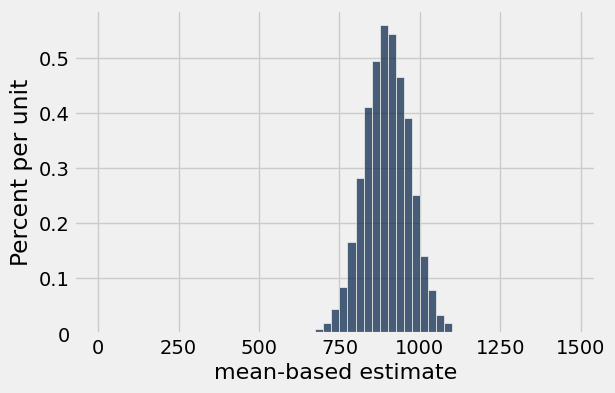

In [9]:
def sample_estimates(serial_num_tbl, statistic, num_replications):
    result = make_array()
    for i in np.arange(num_replications):
        result = np.append(result, statistic(simulate_resample(serial_num_tbl).column(0)))
    return result

# DON'T CHANGE THE CODE BELOW THIS COMMENT!
# This is just an example to test your function.
# This should generate an empirical histogram of twice-mean-based estimates
# of N from samples of size 50 if N is 1000.  This should be a bell-shaped
# curve centered at roughly 900 with most of its mass in [800, 1200].  To verify your
# answer, make sure that's what you see!
population = Table().with_column("serial number", np.arange(1, 1000+1))
one_sample = Table.read_table("one_sample.csv") #This is a sample from the population table
example_estimates = sample_estimates(
    one_sample,
    mean_based_estimator,
    10000)
Table().with_column("mean-based estimate", example_estimates).hist(bins=np.arange(0, 1500, 25))

Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

#### Question 2.4
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *mean-based estimates* of `N`.  Use 5000 replications and save the estimates in an array called `bootstrap_mean_based_estimates`.  

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

<!--
BEGIN QUESTION
name: q2_4
-->

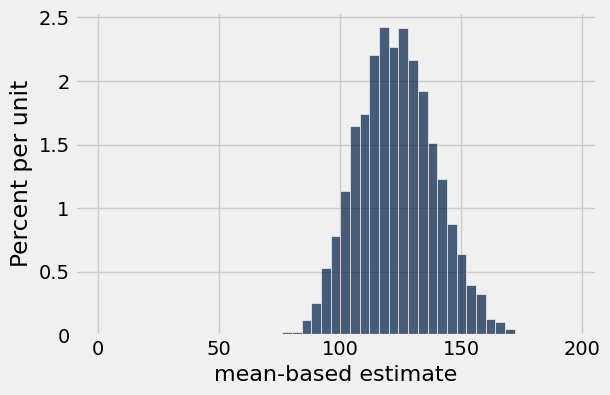

In [10]:
bootstrap_mean_based_estimates = sample_estimates(observations, mean_based_estimator,5000)
# Don't change the code below! This plots bootstrap_mean_based_estimates.
Table().with_column("mean-based estimate", bootstrap_mean_based_estimates).hist(bins=np.arange(0, 200, 4)) 

#### Question 2.5
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *max estimates* of `N`.  Use 5000 replications and save the estimates in an array called `bootstrap_max_estimates`.

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

<!--
BEGIN QUESTION
name: q2_5
-->

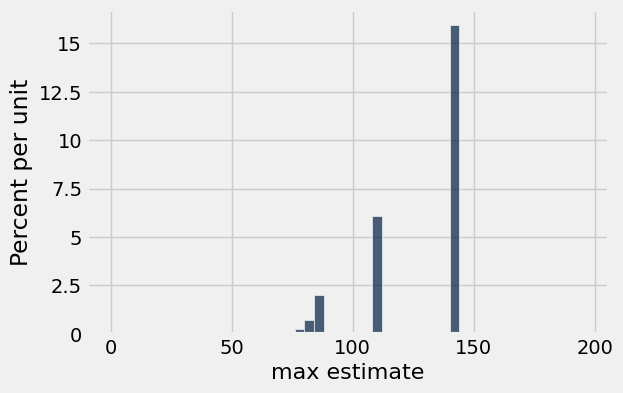

In [11]:
bootstrap_max_estimates = sample_estimates(observations, max, 5000)

# Don't change the code below! This plots bootstrap_max_estimates.
Table().with_column("max estimate", bootstrap_max_estimates).hist(bins=np.arange(0, 200, 4)) 

#### Question 2.6
`N` was actually 150! Compare the histograms of estimates you generated in 2.4 and 2.5 and answer the following questions:

1. How does the distribution of values for the mean-based estimates differ from the max estimates? Do both distributions contain the true max value?
2. Which estimator is more dependent on the original random sample? Why so?

<!--
BEGIN QUESTION
name: q2_6
manual: true
-->
<!-- EXPORT TO PDF -->

1. The mean-based estimates has a wider distribution, and only the mean-based estimates' distribution contain the true max value.

2. The max estimator is more dependent on the original random sample, because it can never exceeds the max value of the original sample, while the mean-based estimator is able to generate a value that exceeds the maximum of the original random sample.

## 3. Computing intervals

#### Question 3.1
Compute an interval that covers the middle 95% of the mean-based bootstrap estimates.  Assign your values to `left_end_1` and `right_end_1`. 

Verify that your interval looks like it covers 95% of the area in the histogram. The red line on the histogram is the value of the parameter (150).

<!--
BEGIN QUESTION
name: q3_1
-->

Middle 95% of bootstrap estimates: [93.176471, 156.117647]


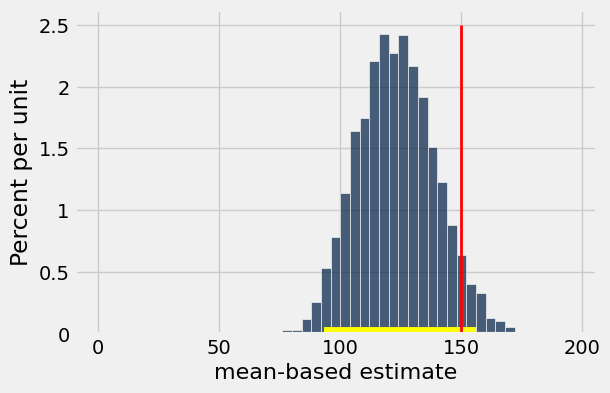

In [12]:
left_end_1 = percentile(2.5, bootstrap_mean_based_estimates)
right_end_1 = percentile(97.5, bootstrap_mean_based_estimates)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end_1, right_end_1))

# Don't change the code below! It draws your interval and N on the histogram of mean-based estimates.
Table().with_column("mean-based estimate", bootstrap_mean_based_estimates).hist(bins=np.arange(0, 200, 4)) 
plt.plot(make_array(left_end_1, right_end_1), make_array(0, 0), color='yellow', lw=10, zorder=1)
plt.plot([150,150], [0, 0.025], color='red', lw=2, zorder=2);

#### Question 3.2
Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations the RAF might have seen by sampling from the `population` table we have created for you below. Use the sample size `num_observations`.
2. Compute an estimate of `N` from these new observations, using `mean_based_estimator`.
3. Using only the new observations, compute 8000 bootstrap estimates of `N`.
4. Plot these bootstrap estimates and compute an interval covering the middle 95%.

*Note:* Traditionally, when we bootstrap using a sample from the population, that sample is usually a simple random sample (i.e., sampled uniformly at random from the population without replacement). However, if the population size is big enough, the difference between sampling with replacement and without replacement is negligible. Think about why that's the case! This is why when we define `new_observations`, we sample with replacement.

<!--
BEGIN QUESTION
name: q3_2
-->

New mean-based estimate: 153.294118
Middle 95% of bootstrap estimates: [116.705882, 189.529412]


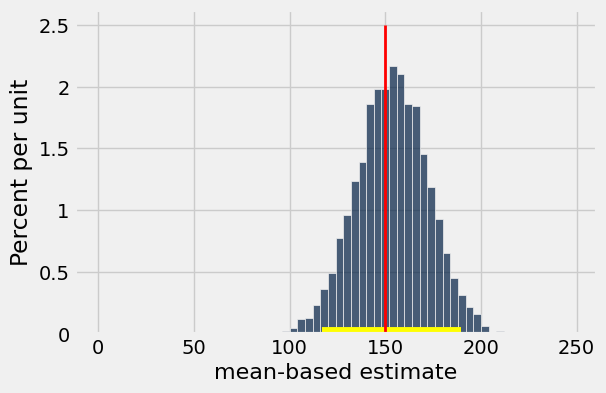

In [17]:
population = Table().with_column("serial number", np.arange(1, 150+1))

new_observations = population.sample(num_observations, with_replacement=True)
new_mean_based_estimate = mean_based_estimator(new_observations.column(0))
new_bootstrap_estimates = sample_estimates(new_observations, mean_based_estimator, 8000)
Table().with_column("mean-based estimate", new_bootstrap_estimates).hist(bins=np.arange(0, 252, 4))
new_left_end = percentile(2.5, new_bootstrap_estimates)
new_right_end = percentile(97.5, new_bootstrap_estimates)

# Don't change code below this line!
print("New mean-based estimate: {:f}".format(new_mean_based_estimate))
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

plt.plot(make_array(new_left_end, new_right_end), make_array(0, 0), color='yellow', lw=10, zorder=1)
plt.plot([150,150], [0, 0.025], color='red', lw=2, zorder=2);

#### Question 3.3
Does the interval covering the middle 95% of the new bootstrap estimates include `N`?  If you ran that cell 100 times and generated 100 intervals, how many of those intervals would you expect to include `N`?

<!--
BEGIN QUESTION
name: q3_3
manual: true
-->
<!-- EXPORT TO PDF -->

Yes, it does include N. If I run the cell 100 times and generated 100 intervals, in about 95 of those intervals I will expect to include N.

Let's look at what happens when we use a small number of resamples:

<img src="smallrephist.png" width="525"/>

This histogram and confidence interval was generated using 10 resamples of `new_observations`.

#### Question 3.4
In the cell below, explain why this histogram and confidence interval look different from the ones you generated previously in Question 3.2 where the number of resamples was 8,000.

<!--
BEGIN QUESTION
name: q3_4
manual: true
-->
<!-- EXPORT TO PDF -->

This histogram contains only 10 resamples of new_observations. The number of resampling is too small for the data to be consistent with the Law  of Large Numbers, so the data is much more unlikely to be the representative of the population.